# Capstone Project - The Battle of the Neighborhoods
### Applied Data Science Capstone by IBM/Coursera

# Most approchable venue in Itagui, Colombia

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find out the most approchable neigborhood to start with a Burger restaurant in Itagui, a town where I came from.

Since there are different places where it can be installed, our stakeholders put as a premise that in the place should be other restaurants near.

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders

First we will import all the libraries needed

In [1]:
#Geocoder to obtain coordenates
from geopy.geocoders import Nominatim
import geocoder

#Kmeans to cluster
from sklearn.cluster import KMeans

#Folium to visualize
import folium 

#To manage requests
import requests

#To operate with dataframes
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

#To do the barcharts
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of existing restaurants in the neighborhood (any type of restaurant)
* number of Burger restaurants in the neighborhood, if any

Following data sources will be needed to extract/generate the required information:
* Name of the Itagui neighborhoods, obtained from <a href="https://www.datos.gov.co/">https://www.datos.gov.co/</a>
* Coordinates of Itagui neigborhoods usin **Nominatin**
* number of restaurants and their type in every neighborhood will be obtained using **Foursquare API**

In [2]:
#Importing data from datos.gov.co
url = 'https://www.datos.gov.co/resource/99ra-mu7g.csv'
df=pd.read_csv(url)
df.drop(['identificacion_del_barrio'], axis = 1, inplace = True) #removing column with unnecessary information
df.head()

,descripcion_del_barrio
0,LA SANTA CRUZ
1,ZONA INDUSTRIAL N 1
2,ZONA INDUSTRIAL N 2
3,ZONA INDUSTRIAL N 3
4,MONTESACRO


In [3]:
#creating columns of latitude and longitude
df['latitude'] = np.nan
df['longitude'] = np.nan
df.head()

,descripcion_del_barrio,latitude,longitude
0,LA SANTA CRUZ,NaN,NaN
1,ZONA INDUSTRIAL N 1,NaN,NaN
2,ZONA INDUSTRIAL N 2,NaN,NaN
3,ZONA INDUSTRIAL N 3,NaN,NaN
4,MONTESACRO,NaN,NaN


In this point we use Nominatin to geolocate the Itagui neighborhoods

In [4]:
geolocator = Nominatim(user_agent="final_proyect_capstone")
for index, rows in df.iterrows():
    #print(rows['descripcion_del_barrio'])
    address = '{}, Itagui, Antioquia, Colombia'.format(rows['descripcion_del_barrio'])
    location = geolocator.geocode(address)
    if location is None:
        latitude = None
        longitude = None
    else:
        latitude = location.latitude
        longitude = location.longitude
    df['latitude'][index] = latitude
    df['longitude'][index] = longitude
    
df.head()

,descripcion_del_barrio,latitude,longitude
0,LA SANTA CRUZ,NaN,NaN
1,ZONA INDUSTRIAL N 1,6.181652,-75.591774
2,ZONA INDUSTRIAL N 2,6.181652,-75.591774
3,ZONA INDUSTRIAL N 3,6.181652,-75.591774
4,MONTESACRO,6.160399,-75.620424


Here we can see that several neighborhoods weren't geolocate. To solve this we try to use other different API as Google Geolocation API but you have to pay to use it.

In [5]:
#In this point we discard all the neighborhoods that we don't have the coordinates
df.dropna(inplace = True)
df.reset_index(drop = True, inplace = True)
df.head()

,descripcion_del_barrio,latitude,longitude
0,ZONA INDUSTRIAL N 1,6.181652,-75.591774
1,ZONA INDUSTRIAL N 2,6.181652,-75.591774
2,ZONA INDUSTRIAL N 3,6.181652,-75.591774
3,MONTESACRO,6.160399,-75.620424
4,YARUMITO,6.161948,-75.623482


Examing the resulting dataframe, we can notice that several neighborhoods have the same coordinates, so we will blend this ones

In [6]:
df2 = pd.DataFrame(df.groupby(['latitude','longitude'])['descripcion_del_barrio'].apply(', '.join))
df2.reset_index(inplace = True)
df2.head()

,latitude,longitude,descripcion_del_barrio
0,6.138364,-75.639189,LA ALDEA
1,6.160399,-75.620424,MONTESACRO
2,6.161518,-75.628841,LA FINCA
3,6.161948,-75.623482,YARUMITO
4,6.162646,-75.614697,PILSEN


In [7]:
df2.at[9, 'descripcion_del_barrio'] = 'SANTA ANA Y OTROS'
df2.at[13, 'descripcion_del_barrio'] = 'SANTA MARIA'
df2.at[15,'descripcion_del_barrio'] = 'ZONA INDUSTRIAL'
df2

,latitude,longitude,descripcion_del_barrio
0,6.138364,-75.639189,LA ALDEA
1,6.160399,-75.620424,MONTESACRO
2,6.161518,-75.628841,LA FINCA
3,6.161948,-75.623482,YARUMITO
4,6.162646,-75.614697,PILSEN
5,6.168138,-75.619008,GLORIETA PILSEN
6,6.168611,-75.628415,DITAIRES
7,6.169264,-75.613296,LA GLORIA
8,6.170050,-75.621060,LA UNION
9,6.172435,-75.609325,SANTA ANA Y OTROS


In [8]:
fixed_columns = [df2.columns[-1]] + list(df2.columns[:-1])
itagui_data = df2[fixed_columns]
itagui_data.head()

,descripcion_del_barrio,latitude,longitude
0,LA ALDEA,6.138364,-75.639189
1,MONTESACRO,6.160399,-75.620424
2,LA FINCA,6.161518,-75.628841
3,YARUMITO,6.161948,-75.623482
4,PILSEN,6.162646,-75.614697


Let's plot the resulting dataset

In [9]:
#Obtain coordinates of Itagui
address = 'Itagui, Antioquia, Colombia'
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Itagui are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Itagui are 6.17648765, -75.6143304501326.


In [10]:
# create map of Itagui using latitude and longitude values
map_itagui = folium.Map(location=[latitude, longitude], zoom_start=13)

# add markers to map
for lat, lng, label in zip(itagui_data['latitude'], itagui_data['longitude'], itagui_data['descripcion_del_barrio']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_itagui)  
    
map_itagui

In the map we can see that *la aldea* was geolocate outside of Itagui, so we will delete it of tha dataframe

In [11]:
itagui_data.drop([0], inplace = True)
itagui_data.reset_index(inplace= True, drop = True)
itagui_data.head()

,descripcion_del_barrio,latitude,longitude
0,MONTESACRO,6.160399,-75.620424
1,LA FINCA,6.161518,-75.628841
2,YARUMITO,6.161948,-75.623482
3,PILSEN,6.162646,-75.614697
4,GLORIETA PILSEN,6.168138,-75.619008


Let's plot again to see if the error was corrected

In [12]:
# Checking with the map that everything is perfect
map_itagui = folium.Map(location=[latitude, longitude], zoom_start=14)


for lat, lng, label in zip(itagui_data['latitude'], itagui_data['longitude'], itagui_data['descripcion_del_barrio']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_itagui)  
    
map_itagui

### Foursquare

now that we have the neighborhoods and their coordinates, lets find the near venues with **Foursquare**

In [13]:
#Defining credentials
CLIENT_ID = '0WGF2AGP4TDHKNF4NW1GAWILT1KSRS1HHUJAXOTFENIIWSHD'
CLIENT_SECRET = '41K52LTOJQQBROHXSVP4CWJGEEBBJWF1RU2MTJUM0B5JLLGT'
VERSION = '20190804' 
radius = 1000
LIMIT = 100

Let's define a function used to obtain nerby venues to each neighborhood

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
#Obtaing Itagui venues
itagui_venues = getNearbyVenues(names=itagui_data['descripcion_del_barrio'],
                                   latitudes=itagui_data['latitude'],
                                   longitudes=itagui_data['longitude']
                                  )

MONTESACRO
LA FINCA
YARUMITO
PILSEN
GLORIETA PILSEN
DITAIRES
LA GLORIA
LA UNION
SANTA ANA Y OTROS
OLIVARES
SIMON BOLIVAR
EL ROSARIO
SANTA MARIA
CALATRAVA
ZONA INDUSTRIAL


In [16]:
#Checking the resulting dataframe size
print(itagui_venues.shape)
itagui_venues.head()

(75, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,MONTESACRO,6.160399,-75.620424,Fabricas Unidas,6.163169,-75.617629,Furniture / Home Store
1,MONTESACRO,6.160399,-75.620424,Ischebeck Colombia,6.160071,-75.622960,Business Service
2,MONTESACRO,6.160399,-75.620424,Parque De San Pio,6.163170,-75.617621,Park
3,MONTESACRO,6.160399,-75.620424,Durespo,6.163099,-75.617447,Department Store
4,LA FINCA,6.161518,-75.628841,Mall Suramérica,6.160941,-75.628006,Shopping Mall


Let's check with a **Horizontal Bar Chart** the neighborhoods with bigger quantity of venues

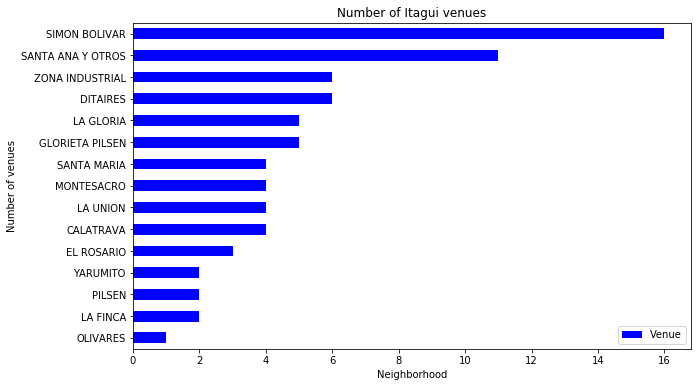

In [46]:
df_barchart = itagui_venues.groupby('Neighborhood').count()[['Venue']]
df_barchart.sort_values(by = 'Venue', inplace = True)

# step 2: plot data
df_barchart.plot(kind='barh', figsize=(10, 6), color='blue')

plt.xlabel('Neighborhood') # add to x-label to the plot
plt.ylabel('Number of venues') # add y-label to the plot
plt.title('Number of Itagui venues') # add title to the plot

plt.show()

In [18]:
print('There are {} uniques categories.'.format(len(itagui_venues['Venue Category'].unique())))

There are 40 uniques categories.


Know, let's check what are the bigger venue category type per neighborhood

In [28]:
# one hot encoding
itagui_onehot = pd.get_dummies(itagui_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
itagui_onehot['Neighborhood'] = itagui_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [itagui_onehot.columns[-1]] + list(itagui_onehot.columns[:-1])
itagui_onehot = itagui_onehot[fixed_columns]
itagui_onehot = itagui_onehot.groupby('Neighborhood').sum()
itagui_onehot

,Athletics & Sports,BBQ Joint,Bar,Big Box Store,Breakfast Spot,Brewery,Burger Joint,Business Service,Café,Creperie,...,Pub,Recreation Center,Restaurant,Sandwich Place,Seafood Restaurant,Shopping Mall,Soccer Field,Sporting Goods Shop,Supermarket,Volleyball Court
Neighborhood,,,,,,,,,,,,,,,,,,,,,
CALATRAVA,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
DITAIRES,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
EL ROSARIO,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
GLORIETA PILSEN,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
LA FINCA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
LA GLORIA,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
LA UNION,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
MONTESACRO,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
OLIVARES,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [20]:
#Function that sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [45]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = pd.Series(itagui_onehot.index.values)

for ind in np.arange(itagui_onehot.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(itagui_onehot.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,CALATRAVA,Hotel,Park,Bar,Restaurant,Furniture / Home Store,Fried Chicken Joint,Food Truck,Fast Food Restaurant,Factory,Dive Bar
1,DITAIRES,Gift Shop,Furniture / Home Store,Juice Bar,Shopping Mall,Museum,Department Store,Fried Chicken Joint,Food Truck,Fast Food Restaurant,Factory
2,EL ROSARIO,Bar,Furniture / Home Store,Seafood Restaurant,Volleyball Court,Department Store,Gift Shop,Fried Chicken Joint,Food Truck,Fast Food Restaurant,Factory
3,GLORIETA PILSEN,Supermarket,Department Store,Fast Food Restaurant,Restaurant,Factory,Gift Shop,Furniture / Home Store,Fried Chicken Joint,Food Truck,Dive Bar
4,LA FINCA,Soccer Field,Shopping Mall,Volleyball Court,Creperie,Furniture / Home Store,Fried Chicken Joint,Food Truck,Fast Food Restaurant,Factory,Dive Bar


## Methodology <a name="methodology"></a>

In this project, we will direct our efforts on detecting neighborhoods of Itagui that have a high number of venues, which means that they are commercial places, with low burgers restaurant density.

In the first step, we have collected the required neighborhoods and their coordinates. We have also identified venues per neighborhood.

Finally, with the 3 neighborhoods with a bigger quantity of venues, we will choose the best one to a new burgers place.

## Analysis <a name="analysis"></a>

In this point we will center our attention on the 3 neighborhoods with the bigger quantity of venues; *SIMON BOLIVAR*, *SANTA ANA* y *ZONA INDUSTRIAL*, because this means that they are or have comercial places.

Let's start ploting this neighborhoods and their venues

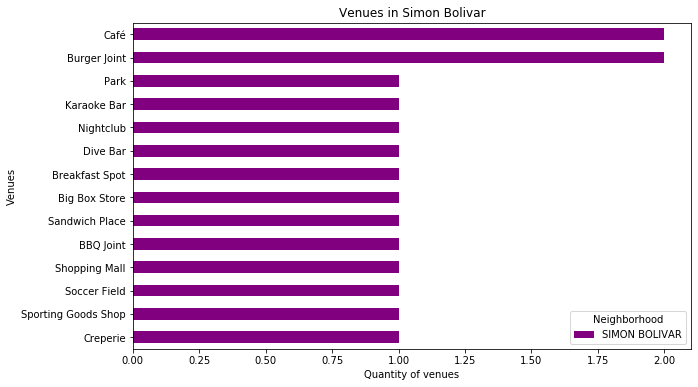

In [50]:
df_simon_bolivar = itagui_onehot.loc[['SIMON BOLIVAR']]
df_simon_bolivar = df_simon_bolivar.transpose() 
df_simon_bolivar.sort_values(by = 'SIMON BOLIVAR', inplace = True)
df_simon_bolivar = df_simon_bolivar[df_simon_bolivar['SIMON BOLIVAR'] != 0]

df_simon_bolivar.plot(kind='barh', figsize=(10, 6), color='purple')
plt.xlabel('Quantity of venues') # add to x-label to the plot
plt.ylabel('Venues') # add y-label to the plot
plt.title('Venues in Simon Bolivar') # add title to the plot
plt.show()

Here we can see that in **Simon Bolivar** are two burger places, so the competition is too much for our stakeholders

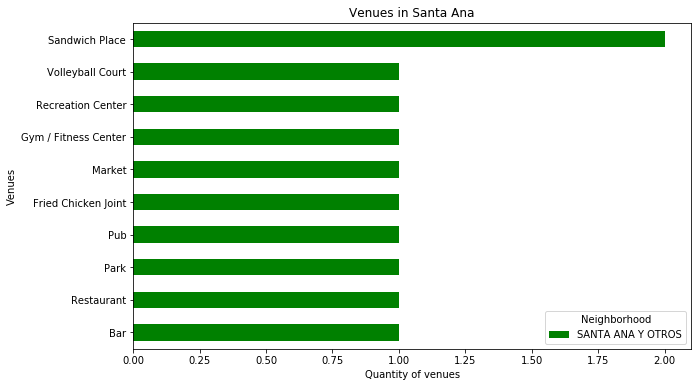

In [43]:
df_simon_bolivar = itagui_onehot.loc[['SANTA ANA Y OTROS']]
df_simon_bolivar = df_simon_bolivar.transpose() 
df_simon_bolivar.sort_values(by = 'SANTA ANA Y OTROS', inplace = True)
df_simon_bolivar = df_simon_bolivar[df_simon_bolivar['SANTA ANA Y OTROS'] != 0]

df_simon_bolivar.plot(kind='barh', figsize=(10, 6), color='green')
plt.xlabel('Quantity of venues') # add to x-label to the plot
plt.ylabel('Venues') # add y-label to the plot
plt.title('Venues in Santa Ana') # add title to the plot
plt.show()

**Santa Ana** looks like the perfect place because we have other restaurants but no burgers restaurants

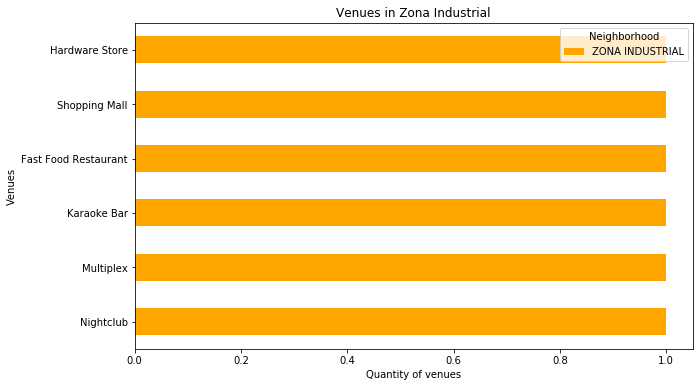

In [44]:
df_simon_bolivar = itagui_onehot.loc[['ZONA INDUSTRIAL']]
df_simon_bolivar = df_simon_bolivar.transpose() 
df_simon_bolivar.sort_values(by = 'ZONA INDUSTRIAL', inplace = True)
df_simon_bolivar = df_simon_bolivar[df_simon_bolivar['ZONA INDUSTRIAL'] != 0]

df_simon_bolivar.plot(kind='barh', figsize=(10, 6), color='orange' )
plt.xlabel('Quantity of venues') # add to x-label to the plot
plt.ylabel('Venues') # add y-label to the plot
plt.title('Venues in Zona Industrial') # add title to the plot
plt.show()

In **Zona Industrial** we can notice that there are a Shopping Mall so, for instance, there should be different burger places, so it is discarded too.

## Conclusion <a name="conclusion"></a>

With the data provided with our analysis, and with my knowledge of the town, we can conclude that Santa Ana is the best neighborhood to start with a burgers place in Itagui. First, there are different other kinds of restaurants, this means traffic of potential customers around our burgers place. And second, if we check the kind of venues that are in Santa Ana, there is not a place of burgers